# gridworld
This is a simple gridworld implementation built in [openai gym](https://gym.openai.com/). The agent (☺) can move left, right, up, and down in user-defined mazes. A `nonterminal_reward` (-1 by default) is emited every step until one of the `terminal_states` is reached, each of which is associated with a user-defined reward. Actions that would move the agent into a wall have no effect on the state, but still cause the `non-terminal reward` to be emitted.

Mazes can be created from scratch or loaded from`rickgrid.mazes`. To create from scratch:

In [1]:
import gym
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import numpy as np
from rickgrid.mazes import mazes
from rickgrid import Agents

%load_ext autoreload
%autoreload 2
np.random.seed(0)

In [15]:

# make a simple maze
env = gym.make(
    'RickGrid-v0',
    walls = np.array([[0,1,0,0,0],           # logical matrix defines wall locations
                      [0,1,1,1,0],
                      [0,0,0,0,0],
                      [1,1,1,1,0],
                      [0,0,0,0,0]], dtype='bool'),
    terminal_states = [[4,0,1], [0,2,10]],   # each terminal state has [row, col, reward]
    start_coords = [0,0],                    # where the agent starts
    nonterminal_reward=-1)                   # -1 reward per non-terminal step

The environment behaves like other environments in openai gym. We can take actions visualize the result as follows:

In [3]:
env.render(); # show maze
env.step(3);  # step down
env.render(); # show maze again


██████████████
██☺ ██10    ██
██  ██████  ██
██          ██
██████████  ██
██ 1        ██
██████████████

██████████████
██  ██10    ██
██☺ ██████  ██
██          ██
██████████  ██
██ 1        ██
██████████████


# model-free control

To 'solve' these mazes, I've implmented Q-Learning, Monte Carlo, [Exact Dynamic Programming](https://web.mit.edu/dimitrib/www/RL_1-SHORT-INTERNET-POSTED.pdf), and Dynamic Programming (as described by [Sutton and Barto](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)). I will test these methods out on this simple default maze:

In [4]:
env = mazes['basic']
env.render();


██████████████
██☺   ██   1██
██    ██    ██
██    ██    ██
██    ██    ██
██          ██
██████████████


## q-learning

We can learn policies using action-value based tabular methods. In this [Q-Learning implementation](), the agent acts $\epsilon$-greedy with respect to the estimated return for each state-action pair, $\hat{q}(s,a)$. These estimates are updated online (after each step) according to

$$\hat{q}(s,a) \leftarrow \hat{q}(s,a) + \alpha [R_t + \gamma \max_{a}\hat{q}(S_{t+1},a) - \hat{q}(s,a)]$$

where $\gamma$ is a discount factor ($\gamma=1$ in this notebook) and $\alpha$ is the learning rate.

Let's train a Q agent!



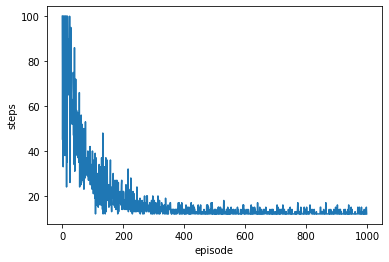

In [5]:
agent = Agents.QLearning(env)
steps, reward = agent.train(
    iterations=1000,
    epsilon=.05,
    alpha=.05,
    gamma=1,
    online_update=True)   # update q on every step

ax = plt.axes(xlabel='episode', ylabel='steps')
ax.plot(steps);

We can can check the resultant policy and $\max_{a} \hat{q}(s,a)$ as follows:


██████████████
██▿ ▿ ██ ▹☺ ██
██▿ ▿ ██ ▹▵ ██
██▿ ▿ ██ ▹▵ ██
██ ▹▿ ██▵ ▵ ██
██ ▹ ▹ ▹▵ ▵ ██
██████████████


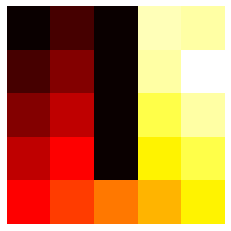

In [6]:
agent.show_policy()
agent.show_q()

## monte carlo

We can also learn $\hat{q}(s,a)$ using a [Monte Carlo method](). Again the agent acts $\epsilon$-greedy, but the expected return for each state-action pair is approximated using an exponentially weighted emperical average. This average is computed incrementally as follows:

$$\hat{q}(s,a) \leftarrow \hat{q}(s,a) + \alpha [G_t - \hat{q}(s,a)]$$

where $G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} \dots \gamma^{T-t} R_T$ and $T$ is the number of time steps in the episode.

Let's train a Monte Carlo agent!



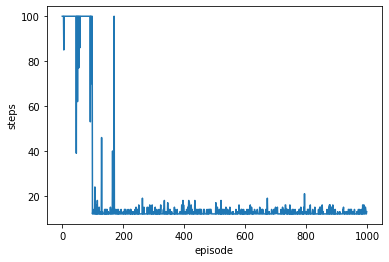

In [7]:
agent = Agents.MonteCarlo(env)
steps, reward = agent.train(
    iterations=1000,
    epsilon=.05,
    alpha=.05,
    gamma=1)

ax = plt.axes(xlabel='episode', ylabel='steps')
ax.plot(steps);

The learning curve is a little goofy. There seems to be an 'aha' moment. The agent has to accidentally discover the terminal location at least once before learning can really occur. This could be problematic for larger state spaces (see below).

# model-based control

## (approximate) dynamic programming

The following approach is referred to in [Sutton and Barto as 'dynamic programming'](http://incompleteideas.net/book/the-book-2nd.html), and by [Dimitri Bertsekas as 'approximate dynamic programming'](https://web.mit.edu/dimitrib/www/RL_1-SHORT-INTERNET-POSTED.pdf). It falls within the 'generalized policy iteration' framework, wherein we iterate between approximating the value function for the current policy (evaluation) and improving the policy based on the value function (improvement).

To evaluate the action-value function for the curent policy we loop across state-action pairs and use the Bellman-like update rule

$$ \hat{q}_\pi(s,a) \leftarrow \hat{q}_\pi(s,a) + \alpha (R_{t+1} + \gamma \hat{q}_\pi(S_{t+1},A_{t+1}) - \hat{q}_\pi(s,a))$$

where $A_{t+1}$ is chosen according to the policy under evaluation.

When the agent is initialized, $\hat{q}_\pi(s,a)=0 \;\; \forall \;\; (s,a)$, which means the actions are selected randomly. Even for this *random policy* a nice structure in the value function emerges after looping over the states `eval_iterations=100` times.

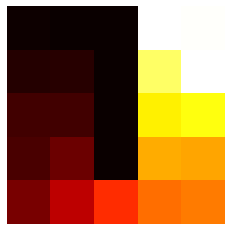

In [8]:
agent = Agents.DP_approx(env)

agent.evaluate_and_update(eval_iterations=1000, alpha=.2, epsilon=.05)
agent.show_q()

Acting greedily with respect to this value function gives us an optimal policy after only a single round of evaluation:

In [9]:
agent.show_policy()  # the policy is now greedy w.r.t the updated q-function


██████████████
██▿ ▿ ██ ▹☺ ██
██▿ ▿ ██▵ ▵ ██
██▿ ▿ ██▵ ▵ ██
██▿ ▿ ██▵ ▵ ██
██ ▹ ▹ ▹▵ ▵ ██
██████████████


A more reasonable approach is to perform evaluation updates for just a few iterations before switching to policy improvement. Learning can occur more quickly this way:


██████████████
██ ▹▿ ██ ▹☺ ██
██ ▹▿ ██▵ ▵ ██
██▿ ▿ ██ ▹▵ ██
██▿ ▿ ██ ▹▵ ██
██ ▹ ▹ ▹ ▹▵ ██
██████████████


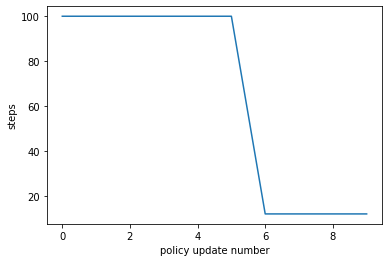

In [10]:
agent = Agents.DP_approx(env)
policy_updates = 10
eval_iterations = 10

steps = []
for i in range(policy_updates):
    
    # evaluate for eval_iterations and update policy once
    agent.evaluate_and_update(eval_iterations=eval_iterations, alpha=.2, epsilon=.05)
    
    # count steps in sample greedy rollout
    rewards = agent.rollout(epsilon=0, alpha=.05, gamma=1)[2]
    steps.append(len(rewards))

# plot steps per episode after each policy update
ax = plt.axes(xlabel='policy update number', ylabel='steps')
ax.plot(steps);

# show policy
agent.show_policy()

## (exact) dynamic programming

In [exact dynamic programming](https://web.mit.edu/dimitrib/www/RL_1-SHORT-INTERNET-POSTED.pdf) the maze is treated as a directed acyclic graph. If the reward emitted between states is treated as the length of the path between those states, then finding the optimal policy is finding the *longest* path through the graph.

The optimal policy is found by working backwards from the terminal states. We rely on the principle of optimality, which states that the remainder of an optimal path is also optimal. At every time, we select the optimal action by maximizing the sum of the immediate reward and the (optimal) value of the subsequent state:

$$ a_{*}(S_t, t) = \max_{a} \left[ r(S_t,A_t) + v_{*}(S_{t+1}, {t+1})  \right] $$

$v_{*}(s,t)$ is the maximum possible (undiscounted) return attainable starting from state $s$ at time $t$, and $r(s,a)$ is the reward emitted after take action $a$ in state $s$. In [the implementation]() I construct action and value matrices that record the optimal values and actions for each state at each time point (assuming a fixed horizon length), starting with the last time point and moving backwards.

There is one subtlety: trajectories can be of different length (because terminal states can be reached at different times), but we would like to create (number of states X number of times) matrices to represent *all* trajectories. The terminal state is therefore treated as a state that transitions to itself without reward until the end of the episode, which makes all trajectories have length $T$. Let's try it out.



In [11]:
agent = Agents.DP_exact(env)
agent.solve()  # this finds the optimal policy
agent.show_policy()


██████████████
██ ▹▿ ██ ▹☺ ██
██ ▹▿ ██ ▹▵ ██
██ ▹▿ ██ ▹▵ ██
██ ▹▿ ██ ▹▵ ██
██ ▹ ▹ ▹ ▹▵ ██
██████████████


#### where exact dynamic programming beats other methods

What's neat about this approach is that the optimal policy is a function of state *and* time, which should allow the policy to do well even when the environment is less Markovian. Consider the following maze, where an extra *non-terminal* reward of 5 is added. An optimal policy should repeatedly consume this reward before running to catch the 99 before the maximimum duration of the episode $(T=100)$ is reached.

In [12]:
env = mazes['loops']
env.render()


██████████████████
██☺             ██
██              ██
██    99        ██
██              ██
██              ██
██           5  ██
██              ██
██████████████████


In [13]:
agent = Agents.DP_exact(env)
agent.solve()  # this finds the optimal policy

rewards = agent.rollout()[2]
print('total reward:')
print(sum(rewards))
print('\nreward sequence:')
print(rewards)

for t in [0,95]:
    print('\n\npolicy at t={}'.format(t))
    agent.show_policy(t=t)

total reward:
258

reward sequence:
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, -1, -1, -1, -1, 99]


policy at t=0

██████████████████
██ ▹ ▹ ▹ ▹ ▹▿  ◃██
██ ▹ ▹ ▹ ▹ ▹▿  ◃██
██ ▹▿ ☺  ▹ ▹▿  ◃██
██ ▹ ▹ ▹ ▹ ▹▿  ◃██
██ ▹ ▹ ▹ ▹ ▹▿  ◃██
██ ▹ ▹ ▹ ▹ ▹ 5 ◃██
██ ▹ ▹ ▹ ▹ ▹▵  ◃██
██████████████████


policy at t=95

██████████████████
██ ▹ ▹▿  ◃ ◃ ◃ ◃██
██ ▹ ▹▿  ◃ ◃ ◃ ◃██
██ ▹ ▹☺  ◃ ◃ ◃ ◃██
██ ▹ ▹▵  ◃ ◃ ◃ ◃██
██ ▹ ▹▵  ◃ ◃ ◃ ◃██
██ ▹ ▹▵  ◃ ◃ 5 ◃██
██ ◃ ▹▵  ◃ ▹▵  ◃██
██████████████████


Nice. The agents keeps consuming the non-terminal reward of $5$ before running to catch the $99$ reward at the last moment (see the reward sequence above). At the beginning it even steers *around* the big reward (see policy at t=0). Whereas the agening moves toward the non-terminal reward at the beginning, it moves toward the big terminal reward near the end.

Q-Learning never achieves the maximum value (see below). Here I increase $\epsilon$ to make sure the $5$ is discovered. Still the agent doesn't receive the maximum possible reward because the policy draws it toward the $99$. This is to be expected. The policy is a function of state but not time, so the agent can't learn that the $5$ is good early on, and the $99$ is good later on.


██████████████████
██ ▹ ▹▿  ◃ ◃▵  ▹██
██ ▹ ▹▿  ◃ ◃ ◃▿ ██
██ ▹ ▹☺  ◃ ◃ ◃ ▹██
██▵ ▵ ▵ ▵ ▵ ▿  ◃██
██▵ ▵ ▵ ▿  ▹▿  ◃██
██ ◃▿  ▹ ◃ ▹ 5 ◃██
██ ◃▵ ▿ ▿  ▹▵  ▹██
██████████████████


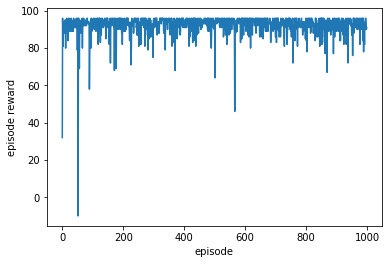

In [14]:
agent = Agents.QLearning(env)
steps, reward = agent.train(iterations=1000, epsilon=.5, online_update=True, alpha=.05, gamma=1)

agent.show_policy()


ax = plt.axes(xlabel='episode', ylabel='episode reward')
ax.plot(reward);

